In [9]:
import pandas as pd
from transformers import AutoTokenizer

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [11]:
import re,string

In [12]:
train = pd.read_csv('./Data/train.csv') # check path!
test = pd.read_csv('./Data/test.csv')
train_len = len(train)

all_data = pd.concat([train,test])

In [13]:
def remove_tag(text):
    tag = re.compile(r'@\S+')
    return re.sub(tag,'',text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url,'',text)

def remove_html(text):
    html = re.compile(r'<[^>]+>|\([^)]+\)')
    return re.sub(html,'',text)

def remove_punct(text):
    punct = list(string.punctuation)
    table = str.maketrans('','',''.join(punct))
    return text.translate(table)

stop = set(stopwords.words('english'))

In [58]:
train_origin = pd.read_csv('./Data/train.csv') # check path!
test_origin = pd.read_csv('./Data/test.csv')

In [14]:
all_data['cleaned'] = all_data['text'].apply(lambda x:remove_tag(x))
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:remove_URL(x))
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:remove_html(x))
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:remove_punct(x))
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:x.lower())
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:word_tokenize(x))
all_data['cleaned'] = all_data['cleaned'].apply(lambda x:' '.join([word for word in x if word not in stop]))
train_data,test_data = all_data[:train_len],all_data[train_len:]

In [15]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self,df,tokenizer,label):
        self.df = df
        self.tokenizer = tokenizer
        self.label = label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        text = self.df.loc[idx]['cleaned']

        encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=82,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=True,
        )

        if self.label:
            labels = self.df.loc[idx]['target']
            return {'input_ids':encoded_dict['input_ids'].squeeze(),
                    'attention_mask':encoded_dict['attention_mask'].squeeze(),
                    'labels':torch.tensor(labels,dtype=torch.long).unsqueeze(dim=0)}
        else:
            return {'input_ids':encoded_dict['input_ids'].squeeze(),
                    'attention_mask':encoded_dict['attention_mask'].squeeze()}

In [16]:
from torch.utils.data import random_split

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TweetsDataset(train_data,tokenizer,True)
test_dataset = TweetsDataset(test_data,tokenizer,False)

train_size = int(len(train_dataset) * 0.8)
valid_size = len(train_dataset) - train_size

train_dataset,valid_dataset = random_split(train_dataset,[train_size,valid_size])

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
train_dataset

In [ ]:
train_data,test_data = all_data[:train_len],all_data[train_len:]

In [19]:
train_data['cleaned']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    control wild fires california even northern pa...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: cleaned, Length: 7613, dtype: object

In [20]:
train_data['tokenized'] = train_data['cleaned'].apply(lambda x:tokenizer.tokenize(x))
train_data['tokenized']

/var/folders/hn/nrs0d2b91f1f7jdk9wdd8yfc0000gn/T/ipykernel_67066/2269184374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['cleaned'].apply(lambda x:tokenizer.tokenize(x))


0       [deeds, reason, earthquake, may, allah, forgiv...
1       [forest, fire, near, la, ron, ##ge, sas, ##k, ...
2       [residents, asked, shelter, place, notified, o...
3       [1300, ##0, people, receive, wild, ##fires, ev...
4       [got, sent, photo, ruby, alaska, smoke, wild, ...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [control, wild, fires, california, even, north...
7610    [m1, ##9, ##4, 01, ##0, ##4, utc, ##5, ##km, v...
7611    [police, investigating, e, ##bi, ##ke, collide...
7612    [latest, homes, ra, ##zed, northern, californi...
Name: tokenized, Length: 7613, dtype: object

In [22]:
train_data['token_len'] = train_data['tokenized'].apply(lambda x:len(x))
train_data['token_len']

/var/folders/hn/nrs0d2b91f1f7jdk9wdd8yfc0000gn/T/ipykernel_67066/1179877217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['token_len'] = train_data['tokenized'].apply(lambda x:len(x))


0        7
1        9
2       11
3        9
4       11
        ..
7608     8
7609    11
7610    11
7611    19
7612    10
Name: token_len, Length: 7613, dtype: int64

In [29]:
y = train_data['token_len'].value_counts()

In [54]:
y.values

array([541, 538, 532, 497, 495, 488, 488, 478, 457, 395, 336, 318, 283,
       279, 226, 213, 198, 173, 149, 128,  80,  74,  56,  46,  42,  26,
        19,  15,  12,   9,   6,   6,   3,   2,   1,   1,   1,   1,   1])

In [44]:
len(y)


39

In [32]:
x = train_data['token_len'].values

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

## Cleaned Text

Text(0, 0.5, 'count')

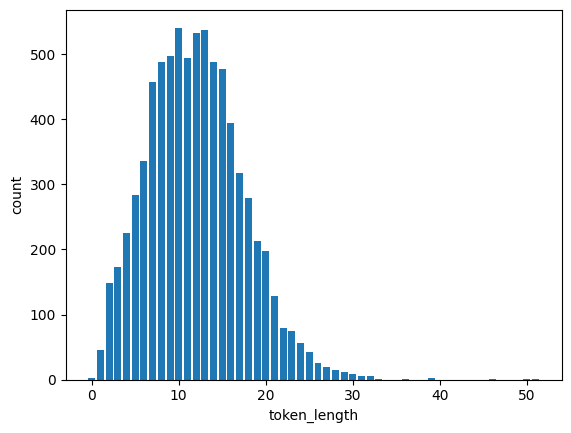

In [57]:
plt.bar(y.index,y.values)
plt.xlabel('token_length')
plt.ylabel('count')

(array([1.970e+02, 6.820e+02, 7.930e+02, 1.526e+03, 1.027e+03, 1.504e+03,
        7.130e+02, 6.900e+02, 2.080e+02, 1.720e+02, 6.000e+01, 2.100e+01,
        1.300e+01, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 0.  ,  2.55,  5.1 ,  7.65, 10.2 , 12.75, 15.3 , 17.85, 20.4 ,
        22.95, 25.5 , 28.05, 30.6 , 33.15, 35.7 , 38.25, 40.8 , 43.35,
        45.9 , 48.45, 51.  ]),
 <BarContainer object of 20 artists>)

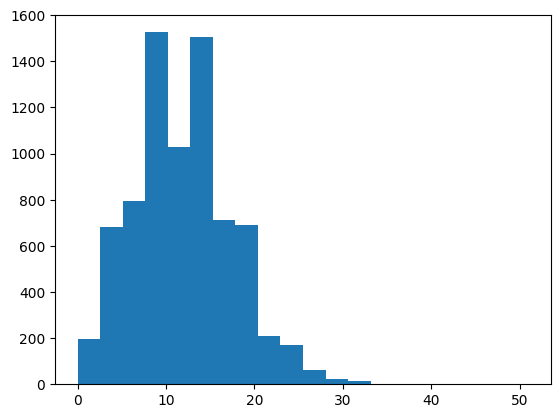

In [49]:
plt.hist(x,bins=20)

In [40]:
y.i

Int64Index([10, 13, 12,  9, 11,  8, 14, 15,  7, 16,  6, 17,  5, 18,  4, 19, 20,
             3,  2, 21, 22, 23, 24,  1, 25, 26, 27, 28, 29, 30, 31, 32, 39,  0,
            33, 50, 46, 51, 36],
           dtype='int64')

## Raw Text

In [ ]:
train_origin = pd.read_csv('./Data/train.csv') # check path!
test_origin = pd.read_csv('./Data/test.csv')

In [60]:
train_origin['tokenized'] = train_origin['text'].apply(lambda x:tokenizer.tokenize(x))
train_origin['tokenized']

0       [our, deeds, are, the, reason, of, this, #, ea...
1       [forest, fire, near, la, ron, ##ge, sas, ##k, ...
2       [all, residents, asked, to, ', shelter, in, pl...
3       [13, ,, 000, people, receive, #, wild, ##fires...
4       [just, got, sent, this, photo, from, ruby, #, ...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [@, aria, _, ah, ##rar, ##y, @, theta, ##wn, #...
7610    [m1, ., 94, [, 01, :, 04, utc, ], ?, 5, ##km, ...
7611    [police, investigating, after, an, e, -, bike,...
7612    [the, latest, :, more, homes, ra, ##zed, by, n...
Name: tokenized, Length: 7613, dtype: object

In [61]:
train_origin['token_len'] = train_origin['tokenized'].apply(lambda x:len(x))
train_origin['token_len']

0       14
1       10
2       25
3       12
4       20
        ..
7608    24
7609    32
7610    32
7611    27
7612    29
Name: token_len, Length: 7613, dtype: int64

In [62]:
x_origin = train_origin['token_len'].values
x_origin

array([14, 10, 25, ..., 32, 27, 29])

In [63]:
len(x_origin)

7613

In [65]:
y_origin = train_origin['token_len'].value_counts()
y_origin

29    279
28    263
30    258
36    248
26    245
     ... 
76      1
1       1
69      1
82      1
71      1
Name: token_len, Length: 74, dtype: int64

<BarContainer object of 74 artists>

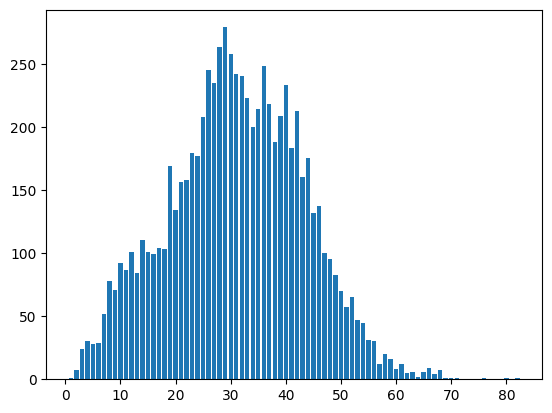

In [72]:
plt.bar(y_origin.index,y_origin.values)

In [71]:
len(y_origin.values)

74